In [ ]:
# FIRST PART
# 1. The word: phonological segments
# 2. The verse: prosody
# 3. The text: metatextual structure

In [1]:
from libscansion import transcribe, nlp, silabas as slbs
from silabeador import silabea
from re import sub

2021-12-03 15:47:00 WARNING: Language es package ancora expects mwt, which has been added
2021-12-03 15:47:00 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | ancora  |

2021-12-03 15:47:00 INFO: Use device: cpu
2021-12-03 15:47:00 INFO: Loading: tokenize
2021-12-03 15:47:00 INFO: Loading: mwt
2021-12-03 15:47:00 INFO: Loading: pos
2021-12-03 15:47:01 INFO: Loading: lemma
2021-12-03 15:47:01 INFO: Loading: depparse
2021-12-03 15:47:02 INFO: Loading: ner
2021-12-03 15:47:03 INFO: Done loading processors!


In [2]:
# A verse
# Let's make a list of it
text = 'Sueña el rico en su riqueza,'.split()

In [ ]:
print(text)

In [ ]:
# Hyphenation (orthographic spelling)
silabea('Sueña')

In [ ]:
syllables = []
[syllables.append(silabea(word)) for word in text]
syllables

In [ ]:
# Phonological transcription (almost)
transcribe('Sueña')

In [ ]:
phonemes = []
[phonemes.append(
    transcribe(sub(r'[^\w\s]','',word)))
               for word in text]
phonemes

In [ ]:
for word in text:
    print(word)
    w = sub(r"[^\w\s]","",word)
    print(f'"{w}"')
    print(transcribe(w))

In [ ]:
morphosyntax = nlp('Sueña el rico en su riqueza')
morphosyntax

In [ ]:
prosody = []
for idx, word in enumerate(phonemes):
    stressed = False
    if morphosyntax.sentences[0].words[idx].upos in ['VERB', 'NOUN', 'ADJ']:
        stressed = True
    prosody.append((word, stressed))
prosody

In [ ]:
sentence = ''
for word in prosody:
    sentence += ' '+' '.join([syllable if word[1] else syllable.strip("'") for syllable in word[0]])
        
print(sentence)

In [ ]:
# Probable lenghts
length = [8, 11, 7]

In [ ]:
# Verse parsing
verso = slbs('Sueña el rico en su riqueza', length)

In [ ]:
# Prosodic stress
verso.silabasmetricas

In [ ]:
verso.ritmo

In [ ]:
verso.rima

In [ ]:
verso.ason

In [ ]:
verso.ml

In [ ]:
verso.nucleosilabico

In [ ]:
verso.ambiguo

In [ ]:
########################################

In [ ]:
# SECOND PART --+---+-

In [ ]:
########################################3
# 1. Modules
# 2. Optional visualisation variables
# 3. Preprocessing functions
# 4. Tabular functions
# 5. Statistic functions
# 6. Body

In [ ]:
# 1. MODULES

In [3]:
# Import modules

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import collections
import re
from statsmodels.multivariate.manova import MANOVA

In [4]:
# 2. VISUALISATION VARIABLES
# Number of lines shown &c.

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [5]:
# 4. TABULAR FUNCTIONS

In [4]:
def samples(data, authors, nsamples):
    import numpy as np
    sample = pd.DataFrame()
    for i in authors:
        g = data.loc[data['Author'] == i].groupby('Title')
        a = np.arange(g.ngroups)
        np.random.shuffle(a)
        sample = sample.append(data.loc[df['Author'] == i][g.ngroup().isin(a[:nsamples])])
    return sample

In [6]:
def recount(data, column):
    rhythmdf = pd.DataFrame()
    values = pd.unique(data[column])
    titles = pd.unique(data['Title'])
    for title in titles:
        nverses = len(data[data['Title'] == title])
        counts = {}
        author =  data.loc[data['Title'] == title]['Author'].value_counts()[:1].index.tolist()[0]
        for value in values:
            row = {'Title': title, 'Author': author}
            count = len(data.loc[data['Title'] == title][data[column] == value])
            relcount = count/nverses
            row = {'Title': title, 'Author': author, column: value, 'Count': count, 'RelCount' : relcount}
            if count > 0:           
                rhythmdf = rhythmdf.append(row, ignore_index=True)
    return rhythmdf.convert_dtypes()

In [7]:
def longformat(data, column, count='Count'):
    longdf = pd.DataFrame()
    titles = pd.unique(data['Title'])
    values = pd.unique(data[column])
    calderon = lope = mira = 0
    for title in titles:
        subset = data[data['Title'] == title]
        author = max(subset['Author'])
        row = {'Author': author, 'Title': title}
        for var in values:
            suma = subset[subset[column] == var]['Count'].sum()
            row.update({var: suma})
        longdf = longdf.append(row, ignore_index=True)
    return longdf.convert_dtypes()

In [8]:
def min_freq(data, column, minimum):
    return data.groupby(column).filter(lambda x : (x[column].count()>=minimum).any()).convert_dtypes()

In [9]:
#5. STATISTIC FUNCTIONS

In [10]:
def analyse(data, j_test=pd.DataFrame(), analisis='k', test=0.2, alea = 42, plot='rbf', n=3):
    X = data.drop('Author', axis=1).values
    y = data['Author'].values
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test, random_state=alea)
    if analisis == 'k':
        from sklearn.neighbors import KNeighborsClassifier
        neighbors = np.arange(1,12)
        train_accuracy =np.empty(len(neighbors))
        test_accuracy = np.empty(len(neighbors))    
        for i,k in enumerate(neighbors):
            modelo = KNeighborsClassifier(n_neighbors=k)
            modelo.fit(X_train,y_train)
            train_accuracy[i] = modelo.score(X_train,y_train)
            test_accuracy[i] = modelo.score(X_test, y_test)
        if plot == 'y':
            plt.rcParams["figure.figsize"] = (10,8)
            plt.title('k-NN number of neighbours')
            plt.plot(neighbors, test_accuracy, label='Test Accuracy')
            plt.plot(neighbors, train_accuracy, label='Training accuracy')
            plt.legend()
            plt.xlabel('Number of neighbours')
            plt.ylabel('Accuracy')
            plt.show()
        else:
            print(test_accuracy)
        modelo = KNeighborsClassifier(n_neighbors=n)
        modelo.fit(X_train,y_train)
    elif analisis == 'r':
        from sklearn.preprocessing import StandardScaler
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
    
        j_test = sc.transform(j_test)
        from sklearn.linear_model import LogisticRegression
        modelo = LogisticRegression(max_iter=1000,  random_state=alea)
        modelo.fit(X_train,y_train)
        y_pred = modelo.predict(X_test)
    elif analisis == 's':
        from sklearn import svm
        modelo = svm.SVC(kernel=plot)
        modelo.fit(X_train,y_train)
    else:
        return False
    from sklearn.metrics import classification_report
    print(f'Score: {modelo.score(X_test,y_test)}')
    from sklearn.metrics import confusion_matrix
    y_pred = modelo.predict(X_test)
    print(modelo.predict(j_test))
    return modelo

In [11]:
#6. IT STARTS HERE

In [12]:
# Load input file
entrada = 'data.csv'
df = pd.read_csv(entrada)
df['Rhythm'] = df['Rhythm'].str.replace('+','X').str.replace('-','o')
df.head()

,Author,Title,Genre,Subgenre,Act,Speech,Verse,Character,Type,Gender,Text,Syllables,Ambiguous,Nuclei,Assonance,Consonance,Rhythm
0,Lope,Auto del pan y el palo,Auto sacramental,ø,0,1,1,BUEN AÑO,NaN,M,"Espérate, Regocijo,",8,0,eEaeeoIo,io,θixo,oXooooXo
1,Lope,Auto del pan y el palo,Auto sacramental,ø,0,1,2,BUEN AÑO,NaN,M,que el viento en las plantas llevas.,8,0,eEeaAaEa,ea,ʎebas,oXooXoXo
2,Lope,Auto del pan y el palo,Auto sacramental,ø,0,2,3,REGOCIJO,NaN,M,Engéndranme buenas nuevas,8,0,eEaeEaEa,ea,nwebas,oXooXoXo
3,Lope,Auto del pan y el palo,Auto sacramental,ø,0,2,4,REGOCIJO,NaN,M,si sabes que soy su hijo.,8,0,iAeeOuIo,io,ixo,oXooXoXo
4,Lope,Auto del pan y el palo,Auto sacramental,ø,0,2,5,REGOCIJO,NaN,M,¿Qué me mandas esperar?,8,0,EeAaeeA,a,ɾaɾ,XoXoooX


In [13]:
# Show authors
authors = df['Author'].unique()
print(authors)

['Lope' 'Mira' 'Calderón' 'X']


In [14]:
# Show titles
titles = df['Title'].unique()
len(titles)
print(titles)

['Auto del pan y el palo' 'El heredero' 'El hijo pródigo'
 'El jardín de Falerina' 'El laberinto del mundo' 'El misacantano'
 'El niño pastor' 'El pintor de su deshonra' 'El sacro Pernaso'
 'El viaje del alma' 'La guarda cuidadosa' 'La inquisición' 'La maya'
 'La mayor soberbia humana de Nabucodonosor' 'La santa Margarita'
 'Las bodas entre el Alma y el Amor Divino' 'Los acreedores del hombre'
 'Pedro Telonario' 'Primero y segundo Isaac' 'La hidalga del valle'
 'La protestación de la fe' 'La divina Filotea' 'La piel de Gedeón'
 'Las espigas de Ruth' 'Psiquis y Cupido (Madrid)' 'El nombre de Jesús'
 'Las hazañas del segundo David' 'El erario y monte de la piedad'
 'El rico avariento' 'La casa de Austria' 'Nuestra Señora de los Remedios']


In [14]:
df.groupby(['Author','Title']).size()

Author    Title                                    
Calderón  El jardín de Falerina                        1894
          El laberinto del mundo                       1998
          El pintor de su deshonra                     1737
          El sacro Pernaso                             1994
          La divina Filotea                            1981
          La piel de Gedeón                            1740
          La protestación de la fe                     1669
          Las espigas de Ruth                          1759
          Primero y segundo Isaac                      1811
          Psiquis y Cupido (Madrid)                    1860
Lope      Auto del pan y el palo                       1032
          El hijo pródigo                              1388
          El misacantano                                789
          El niño pastor                               1089
          El nombre de Jesús                           1414
          El viaje del alma                     

In [15]:
# Yo make things simpler later
all_authors = ['Calderón', 'Lope', 'Mira', 'X']
candidates = ['Calderón', 'Lope', 'Mira']
disputed = 'X'

In [16]:
# I just want octosyllabic verses
df = df.loc[df['Syllables'] == 8]

In [17]:
# Candidates
candidatesdf = df[df['Author'] != disputed]

# Disputed
disputeddf = df.loc[df['Author'] == disputed]

In [18]:
# I don't want very unusual hythms 
df = min_freq(df, 'Rhythm',  100)

disputeddf = df.loc[df['Author'] == disputed]
candidatesdf = df.loc[df['Author'] != disputed]

In [19]:
# Count rhythms
dfcount = recount(df, 'Rhythm')
dfcandidatescount = recount(candidatesdf, 'Rhythm')

<ipython-input-6-beb7887def7f>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  count = len(data.loc[data['Title'] == title][data[column] == value])


In [20]:
dfcount

,Author,Count,RelCount,Rhythm,Title
0,Lope,34,0.035602,oXooooXo,Auto del pan y el palo
1,Lope,58,0.060733,oXooXoXo,Auto del pan y el palo
2,Lope,19,0.019895,XoXoooX,Auto del pan y el palo
3,Lope,14,0.014660,XXooXoX,Auto del pan y el palo
4,Lope,37,0.038743,oXoXooX,Auto del pan y el palo
5,Lope,20,0.020942,ooooXoX,Auto del pan y el palo
6,Lope,6,0.006283,oXXoooX,Auto del pan y el palo
7,Lope,12,0.012565,ooXXooXo,Auto del pan y el palo
8,Lope,54,0.056545,oXoXooXo,Auto del pan y el palo
9,Lope,18,0.018848,XoXoXoX,Auto del pan y el palo


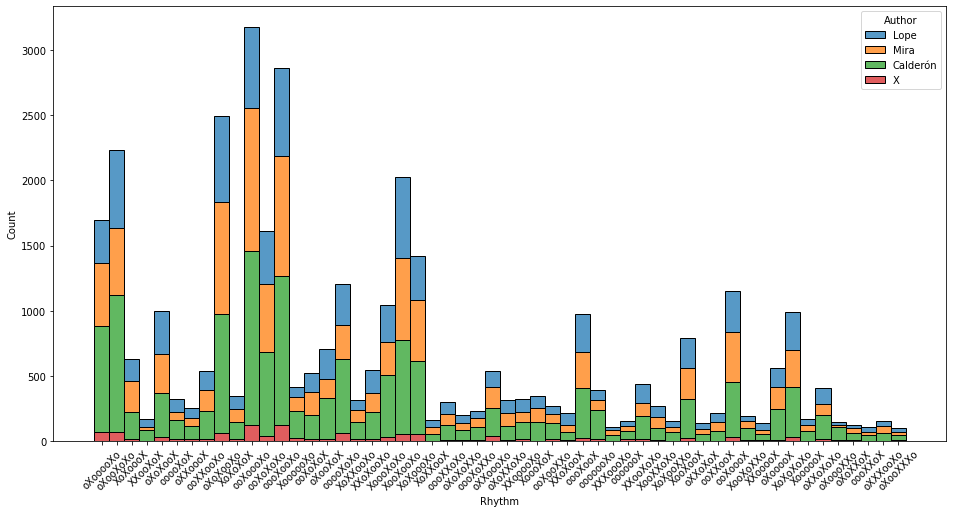

In [20]:
# Histogram
plt.figure(figsize=(16,8))
plt.xticks(rotation=45)
plot = sns.histplot(x='Rhythm', hue='Author', data=df, multiple="stack") #, palette=paleta,multiple='stack'

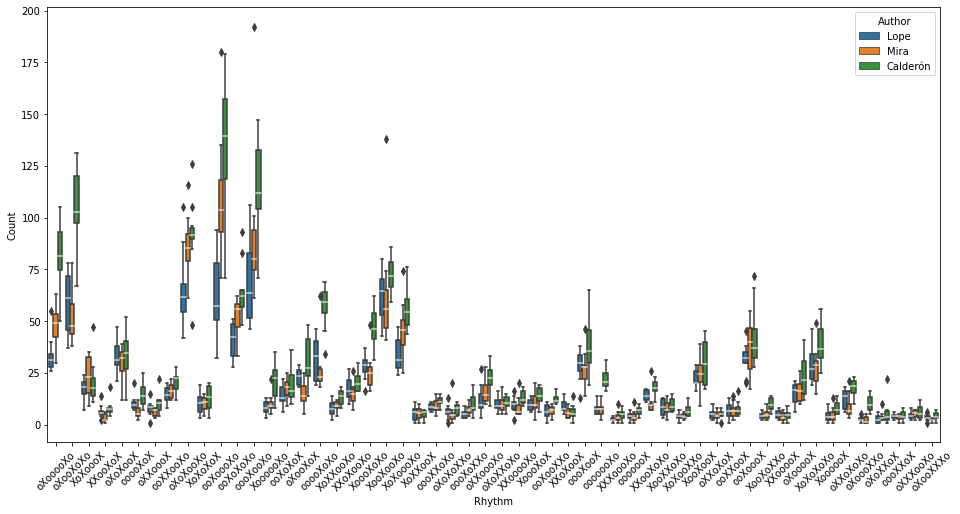

In [21]:
# Variance (boxes)
plt.figure(figsize=(16,8))
plt.xticks(rotation=45)
plot = sns.boxplot(x='Rhythm', y='Count', hue='Author', data=dfcandidatescount, medianprops=dict(color="white", alpha=0.7))


In [22]:
# Long format (Each rhtyhm is a column)
dflong = longformat(dfcount, 'Rhythm', 'Count')
dfcandidateslong = longformat(dfcandidatescount, 'Rhythm', 'Count')

In [24]:
dflong

,Author,Title,XXXoooXo,XXoXooX,XXoXooXo,XXooXoX,XXooXoXo,XXooooX,XXooooXo,XoXXooX,XoXXooXo,XoXoXoX,XoXoXoXo,XoXooXXo,XoXoooX,XoXoooXo,XooXXoXo,XooXoXXo,XooXooX,XooXooXo,XoooXoX,XoooXoXo,XoooooX,XoooooXo,oXXXooXo,oXXoXoX,oXXoXoXo,oXXoooX,oXXoooXo,oXoXXoX,oXoXXoXo,oXoXoXXo,oXoXooX,oXoXooXo,oXooXXXo,oXooXoX,oXooXoXo,oXoooXXo,oXooooX,oXooooXo,ooXXooX,ooXXooXo,ooXoXoX,ooXoXoXo,ooXooXXo,ooXoooX,ooXoooXo,oooXXoX,oooXXoXo,oooXoXXo,oooXooX,oooXooXo,ooooXoX,ooooXoXo,ooooooX,ooooooXo
0,Lope,Auto del pan y el palo,2,11,17,14,14,3,14,8,4,18,21,3,19,29,6,3,29,56,12,22,4,11,0,8,7,6,19,1,11,7,37,54,0,27,58,3,19,34,5,12,14,40,2,35,61,4,7,6,38,51,20,38,3,8
1,Mira,El heredero,10,4,12,6,26,6,20,8,10,12,34,2,34,74,2,10,24,138,18,48,8,22,6,8,16,4,28,2,18,20,24,116,2,18,78,4,26,62,8,20,20,62,6,54,180,4,12,12,34,192,8,62,2,8
2,Lope,El hijo pródigo,4,7,23,7,12,7,10,9,8,14,36,3,24,31,10,7,20,66,7,31,1,6,8,2,16,5,8,6,9,6,29,59,3,29,37,0,14,28,1,14,6,33,5,21,48,3,10,9,29,50,7,21,4,5
3,Calderón,El jardín de Falerina,2,4,19,7,11,1,11,6,13,7,31,4,13,52,6,5,18,65,13,42,7,16,6,1,15,6,19,4,14,8,26,89,3,24,84,8,12,74,5,14,10,60,12,28,120,8,11,7,19,107,7,64,5,16
4,Calderón,El laberinto del mundo,7,5,25,8,23,3,16,7,9,11,38,12,18,48,15,13,22,80,17,62,5,23,9,4,17,7,27,3,14,10,33,126,7,22,131,11,23,94,9,23,13,65,17,40,155,4,10,12,22,128,18,64,5,21
5,Lope,El misacantano,2,7,13,4,12,5,11,1,2,6,27,6,7,27,7,0,20,43,6,29,2,7,2,0,16,6,8,2,12,6,21,42,1,18,51,2,9,26,4,12,12,49,1,20,54,2,6,3,13,46,9,19,4,10
6,Lope,El niño pastor,4,8,16,2,15,3,7,2,5,6,19,2,17,26,4,7,26,63,12,25,10,7,3,6,10,9,9,2,9,1,30,67,2,18,72,3,15,26,10,11,12,28,4,30,52,6,8,5,33,62,9,33,5,6
7,Calderón,El pintor de su deshonra,9,9,24,7,17,5,18,6,18,20,56,13,28,60,8,14,40,71,19,44,5,11,3,6,22,11,19,7,5,10,36,85,7,23,99,12,20,76,5,21,10,55,14,36,118,1,11,8,31,103,13,34,7,20
8,Calderón,El sacro Pernaso,6,3,30,4,21,3,16,1,15,7,32,6,11,76,14,10,25,70,6,62,5,35,8,6,19,10,33,3,9,4,30,96,5,27,122,5,13,91,8,16,16,93,12,31,162,4,15,5,42,147,8,58,5,30
9,Lope,El viaje del alma,2,5,14,5,14,4,2,2,11,5,26,1,12,24,11,2,16,52,9,29,3,10,4,3,7,15,10,1,6,2,26,55,3,24,42,5,19,33,3,15,11,30,4,30,50,4,11,3,29,53,8,21,1,5


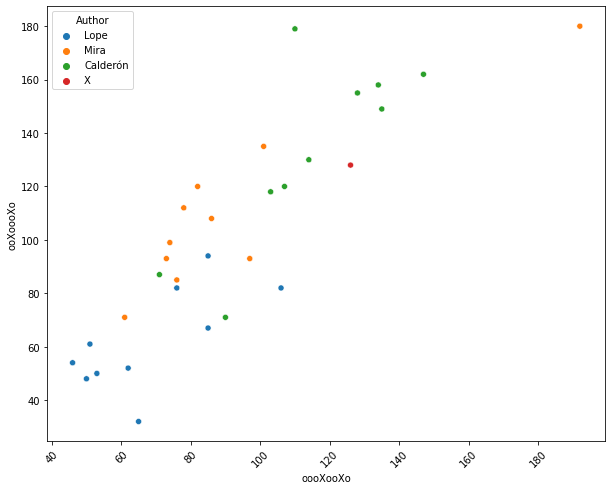

In [28]:
# Scatterplot (dots)- 
plt.xticks(rotation=45)
plot = sns.scatterplot(data=dflong, x='oooXooXo', y='ooXoooXo', hue="Author") #        oXooXoXo oXooXoXo oXooXoX oooXooXo

ERROR! Session/line number was not unique in database. History logging moved to new session 210



******************************************
\Title:	X: La hidalga del valle

Regresion
Score: 1.0
['Calderón']

-------------------------------------------------------

SVN
Score: 1.0
['Calderón']

-------------------------------------------------------

Knn:



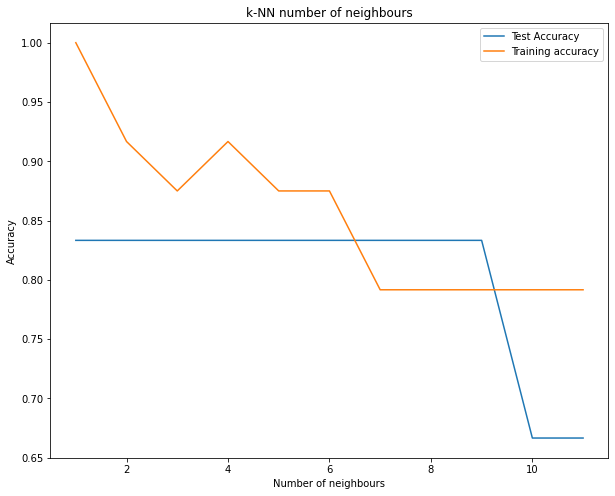

Score: 0.8333333333333334
['Calderón']


KNeighborsClassifier(n_neighbors=4)

In [23]:
# Logistic regresion k-NN & SVN
# PArameters sampling
testr = 0.01
testk = 0.2
tests = 0.01
# Randomisation factor (the answer to life, the universe and everything)
alea = 42
# Number of neighbours
kn = 4
# Just the required columns
data = dflong.drop('Title', axis=1)


#def analyse(tabla, j_test=pd.DataFrame(), test=0.2, alea = 42, plot='n', analisis='k',  n=12):
print(f'\n\n\n******************************************\n\Title:\tX: {dflong.loc[dflong["Author"] == "X"]["Title"].max()}\n')
trainer = data.loc[data['Author'].isin(candidates)]
to_test = data.loc[data['Author'] == 'X'].drop('Author', axis=1).values
    
print('Regresion')
analyse(trainer, to_test, 'r', testr, alea,'n', 3)
  
print('\n-------------------------------------------------------\n\nSVN')
    #testY = dfreglargo[dfreglargo['Autor'] == autor].drop('Autor', axis=1).values
analyse(trainer, to_test,  's', tests, alea, 'rbf')
    
print('\n-------------------------------------------------------\n\nKnn:\n')
analyse(trainer, to_test,  'k', testk, alea, 'y', kn)